In [1]:
!pip install accelerate bert-score rouge-score nltk python-Levenshtein

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=2

In [2]:
import pandas as pd

metadata_path = "/kaggle/input/abo-small/metadata/images.csv"
df = pd.read_csv(metadata_path)
df.head()
print("Total images:", len(df))

Total images: 398212


🖼️ Image ID: 010-mllS7JL
📏 Dimensions: 106x106
📂 Path: /kaggle/input/abo-small/small/14/14fe8812.jpg


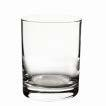

🖼️ Image ID: 01dkn0Gyx0L
📏 Dimensions: 122x122
📂 Path: /kaggle/input/abo-small/small/da/daab0cad.jpg


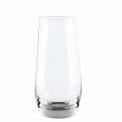

🖼️ Image ID: 01sUPg0387L
📏 Dimensions: 111x111
📂 Path: /kaggle/input/abo-small/small/d2/d2daaae9.jpg


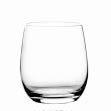

🖼️ Image ID: 1168jc-5r1L
📏 Dimensions: 186x186
📂 Path: /kaggle/input/abo-small/small/3a/3a4e88e6.jpg


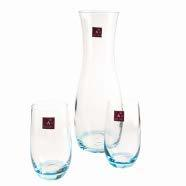

🖼️ Image ID: 11RUV5Fs65L
📏 Dimensions: 30x500
📂 Path: /kaggle/input/abo-small/small/d9/d91ab9cf.jpg


In [3]:
import os
from PIL import Image
from IPython.display import display

# Base directory where the actual image folders are located
image_base_path = "/kaggle/input/abo-small/small"

# Sample a few rows to visualize
sample_df = df.head()

for _, row in sample_df.iterrows():
    image_path = os.path.join(image_base_path, row["path"])
    print(f"🖼️ Image ID: {row['image_id']}")
    print(f"📏 Dimensions: {row['height']}x{row['width']}")
    print(f"📂 Path: {image_path}")
    
    try:
        img = Image.open(image_path).convert("RGB")
        display(img)
    except Exception as e:
        print("⚠️ Could not load image:", e)


In [4]:
vqa_dataset_path = "/kaggle/input/vqa-dataset/VQA_Dataset.csv"
vqa_df = pd.read_csv(vqa_dataset_path)
vqa_df.head()
print("Total questions:", len(vqa_df))

Total questions: 64406


In [5]:
# Create a lookup dictionary from the image metadata
id_to_path_full = dict(zip(df["image_id"], df["path"]))

# Filter only those image_ids that are actually in the VQA dataset
vqa_image_ids = set(vqa_df["image_id"])
vqa_id_to_path = {img_id: id_to_path_full[img_id] for img_id in vqa_image_ids if img_id in id_to_path_full}

print(f"✅ Mapped {len(vqa_id_to_path)} image_ids from VQA dataset to image paths.")

✅ Mapped 20344 image_ids from VQA dataset to image paths.


In [6]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import BlipProcessor, BlipForQuestionAnswering
import torch
from accelerate import Accelerator

# Initialize Accelerator
accelerator = Accelerator()

# # Load BLIP-1 VQA model and processor
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Load model directly
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering

processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = AutoModelForVisualQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Move model to the appropriate device (GPU or CPU)
model = accelerator.prepare(model)
model.eval()

2025-05-13 18:48:11.029193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747162091.201492      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747162091.255986      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(vqa_df, test_size=0.2, random_state=51)

In [ ]:
import os
import warnings
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import contextlib
import io
import nltk
from sklearn.metrics import f1_score, precision_score, recall_score
from bert_score import score as bert_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from Levenshtein import distance as levenshtein_distance

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

eval_log_path = "vqa_eval_metrics.txt"
open(eval_log_path, "w").close()

# Token-level F1
def compute_token_f1(predictions, references):
    f1s = []
    for pred, gt in zip(predictions, references):
        pred_tokens = set(nltk.word_tokenize(pred))
        gt_tokens = set(nltk.word_tokenize(gt))
        common = pred_tokens.intersection(gt_tokens)
        if len(common) == 0:
            f1s.append(0.0)
        else:
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(gt_tokens)
            f1 = 2 * precision * recall / (precision + recall)
            f1s.append(f1)
    return sum(f1s) / len(f1s)

# Exact match F1
def compute_exact_f1(predictions, references):
    binary_preds = [int(pred == gt) for pred, gt in zip(predictions, references)]
    binary_refs = [1] * len(references)
    return f1_score(binary_refs, binary_preds), precision_score(binary_refs, binary_preds), recall_score(binary_refs, binary_preds)

# Substring match F1
def compute_substring_f1(predictions, references):
    binary_preds = [int(gt in pred) for pred, gt in zip(predictions, references)]
    binary_refs = [1] * len(references)
    return f1_score(binary_refs, binary_preds), precision_score(binary_refs, binary_preds), recall_score(binary_refs, binary_preds)

def evaluate_and_log(generated_answers, ground_truth_answers, step):
    exact_matches = [pred == gt for pred, gt in zip(generated_answers, ground_truth_answers)]
    exact_accuracy = sum(exact_matches) / len(exact_matches) if exact_matches else 0.0

    substring_matches = [gt in pred for pred, gt in zip(generated_answers, ground_truth_answers)]
    substring_accuracy = sum(substring_matches) / len(substring_matches) if substring_matches else 0.0

    f1_macro = compute_token_f1(generated_answers, ground_truth_answers)
    f1_exact, precision_exact, recall_exact = compute_exact_f1(generated_answers, ground_truth_answers)
    f1_substring, precision_substring, recall_substring = compute_substring_f1(generated_answers, ground_truth_answers)

    P, R, F1 = bert_score(generated_answers, ground_truth_answers, lang="en", verbose=False)
    bertscore_f1 = F1.mean().item()

    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = [rouge.score(gt, pred)['rougeL'].fmeasure for pred, gt in zip(generated_answers, ground_truth_answers)]
    rouge_l_avg = sum(rouge_l_scores) / len(rouge_l_scores)

    smoothie = SmoothingFunction().method4
    references = [[gt.split()] for gt in ground_truth_answers]
    candidates = [pred.split() for pred in generated_answers]

    bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    meteor_scores = [meteor_score([nltk.word_tokenize(gt)], nltk.word_tokenize(pred)) for pred, gt in zip(generated_answers, ground_truth_answers)]
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    lev_scores = [levenshtein_distance(pred, gt) / max(len(pred), len(gt), 1) for pred, gt in zip(generated_answers, ground_truth_answers)]
    avg_lev = 1 - sum(lev_scores) / len(lev_scores)

    with open(eval_log_path, "a") as f:
        f.write(f"\n--- Evaluation at step {step} ---\n")
        f.write(f"Exact Match Accuracy     : {exact_accuracy * 100:.2f}%\n")
        f.write(f"Substring Match Accuracy : {substring_accuracy * 100:.2f}%\n")
        f.write(f"Token-level Macro F1     : {f1_macro * 100:.2f}%\n")
        f.write(f"Exact Match F1           : {f1_exact * 100:.2f}%\n")
        f.write(f"Exact Match Precision    : {precision_exact * 100:.2f}%\n")
        f.write(f"Exact Match Recall       : {recall_exact * 100:.2f}%\n")
        f.write(f"Substring Match F1       : {f1_substring * 100:.2f}%\n")
        f.write(f"Substring Match Precision: {precision_substring * 100:.2f}%\n")
        f.write(f"Substring Match Recall   : {recall_substring * 100:.2f}%\n")
        f.write(f"BERTScore F1             : {bertscore_f1 * 100:.2f}%\n")
        f.write(f"ROUGE-L F1               : {rouge_l_avg * 100:.2f}%\n")
        f.write(f"BLEU-1                     : {bleu1 * 100:.2f}%\n")
        f.write(f"BLEU-2                     : {bleu2 * 100:.2f}%\n")
        f.write(f"BLEU-3                     : {bleu3 * 100:.2f}%\n")
        f.write(f"BLEU-4                     : {bleu4 * 100:.2f}%\n")
        f.write(f"METEOR Score             : {avg_meteor * 100:.2f}%\n")
        f.write(f"Levenshtein Similarity   : {avg_lev * 100:.2f}%\n")



# Inference loop
generated_answers = []
ground_truth_answers = []
skipped = 0
skip_logs = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row["question"]
    gt_answer = str(row["answer"]).strip().lower()
    image_id = row["image_id"]

    image_rel_path = vqa_id_to_path.get(image_id)
    if image_rel_path is None:
        skip_logs.append(f"[SKIP] No path for image_id {image_id} (index {idx})")
        skipped += 1
        continue

    full_path = os.path.join(image_base_path, image_rel_path)
    if not os.path.exists(full_path):
        skip_logs.append(f"[SKIP] Image not found: {full_path}")
        skipped += 1
        continue

    try:
        image = Image.open(full_path).convert("RGB")
    except Exception as e:
        skip_logs.append(f"[SKIP] Failed to load image: {full_path} | Error: {e}")
        skipped += 1
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            inputs = processor(images=image, text=question, return_tensors="pt").to("cuda", torch.float16)
            output = model.generate(**inputs, max_new_tokens=10)
            pred_answer = processor.decode(output[0], skip_special_tokens=True).strip().lower()

    generated_answers.append(pred_answer)
    ground_truth_answers.append(gt_answer)

    if len(generated_answers) % 100 == 0:
        evaluate_and_log(generated_answers, ground_truth_answers, len(generated_answers))

# Final evaluation
evaluate_and_log(generated_answers, ground_truth_answers, len(generated_answers))

# Print skip logs
if skip_logs:
    print("\n🛑 Skipped Entries:")
    for log in skip_logs:
        print(log)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
  1%|          | 99/12882 [00:10<20:03, 10.62it/s] 

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 198/12882 [00:35<20:02, 10.55it/s]  Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 299/12882 [00:46<18:58, 11.05it/s]  Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 399/12882 [00:56<19:01, 10.94it/s]  Some weights 

NameError: name 'subset_vqa_df' is not defined